In [2]:
import pandas as pd
import torch
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

D:\After\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

D:\After\torch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [5]:
data_path = "../data/"
ratings_df = pd.read_csv(data_path + "jester_ratings.csv")
jokes_df = pd.read_csv(data_path + "jester_items.csv")
# display(ratings_df.head(3))

In [8]:
# 1. Text Embedding using DistilBERT
def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding for each joke
    return outputs.last_hidden_state[:, 0, :].mean(dim=0).cpu().numpy()

jokes_df['embedding'] = jokes_df['jokeText'].apply(embed_text)

In [9]:
jokes_df['embedding'][0].shape 

(768,)

In [10]:
# 2. User Profile Construction
def build_user_profile(user_id):
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    high_rated_jokes = user_ratings[user_ratings['rating'] >= 4]
    if high_rated_jokes.empty:
        return None
    
    joke_embeddings = jokes_df[jokes_df['jokeId'].isin(high_rated_jokes['jokeId'])]['embedding']
    user_profile = sum(joke_embeddings) / len(joke_embeddings)
    return user_profile

In [11]:
# 3. Recommendation
def recommend_jokes(user_id, top_n=3):
    user_profile = build_user_profile(user_id)
    if user_profile is None:
        return pd.DataFrame(columns=['jokeId', 'jokeText', 'similarity'])

    similarities = cosine_similarity([user_profile], jokes_df['embedding'].tolist()).flatten()
    jokes_df['similarity'] = similarities
    recommended_jokes = jokes_df.sort_values(by='similarity', ascending=False).head(top_n)
    
    return recommended_jokes[['jokeId', 'jokeText', 'similarity']]

In [14]:
# 4. Metrics and Visualizations
def evaluate_and_visualize(user_id, top_n=3):
    recommended_jokes = recommend_jokes(user_id, top_n=top_n)
    print(f"Recommended Jokes for User {user_id}")
    print(recommended_jokes)

    if recommended_jokes.empty:
        print("No recommendations available for this user.")
        return

    # Visualize similarity scores with top N recommendations
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='jokeId', y='similarity', data=recommended_jokes, palette="viridis")
    plt.title(f"Similarity Scores for Recommended Jokes (User {user_id})")
    plt.xlabel("Joke ID")
    plt.ylabel("Similarity Score")
    plt.ylim(0, 1)
    
    for index, row in recommended_jokes.iterrows():
        plt.text(row['jokeId'], row['similarity'] + 0.01, f'{row["similarity"]:.2f}', color='black', ha="center")
    
    plt.show()

    # Visualize embedding distances with annotations for top N recommendations
    user_profile = build_user_profile(user_id)
    joke_embeddings = jokes_df['embedding'].tolist()
    distances = cosine_similarity([user_profile], joke_embeddings).flatten()

    plt.figure(figsize=(12, 6))
    sns.histplot(distances, bins=30, kde=True, color='skyblue')
    plt.title(f"Similarity Distribution Between User {user_id}'s Profile and All Jokes")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    
    # Mark top N recommendations
    top_similarities = recommended_jokes['similarity'].tolist()
    for similarity in top_similarities:
        plt.axvline(x=similarity, color='red', linestyle='--', label='Top Recommendation' if similarity == top_similarities[0] else "")

    plt.legend()
    plt.show()

Recommended Jokes for User 10
     jokeId                                           jokeText  similarity
147     148  Recently a teacher, a garbage collector, and a...    0.967802
105     106  An engineer dies and reports to the pearly gat...    0.967603
36       37  A Jewish young man was seeing a psychiatrist f...    0.965157


C:\Users\OMEN\AppData\Local\Temp\ipykernel_19436\1922669102.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='jokeId', y='similarity', data=recommended_jokes, palette="viridis")


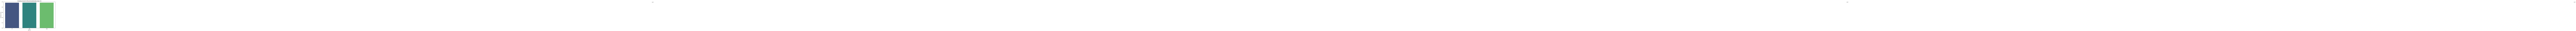

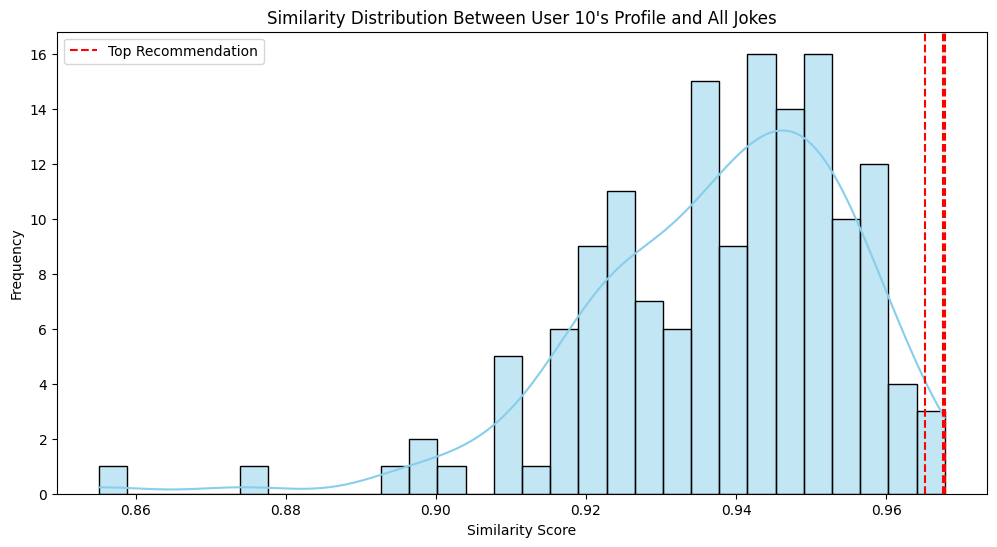

In [16]:
user_id = 10
evaluate_and_visualize(user_id)